# Case Studies: Case Study 4; Accurate continuum limit

This example shows how we obtained the results in the paper
for the fourth case study, for the case that the continuum limit is
accurate. Let us load in the packages we will need.

In [1]:
using StepwiseEQL
using CairoMakie
using EpithelialDynamics1D
using OrdinaryDiffEq
using Random

## Simulating
Let us start by defining the cell problem. We use the force law $F(\ell) = k(s-\ell)$
and the proliferation law $G(\ell) = \beta[1 - 1/(K\ell)]$.

In [2]:
final_time = 100.0
domain_length = 30.0
midpoint = domain_length / 2
initial_condition = [LinRange(0, 5, 30);] |> unique!
damping_constant = 1.0
resting_spring_length = 0.2
spring_constant = 50.0
k = spring_constant
η = damping_constant
s = resting_spring_length
force_law_parameters = (s=resting_spring_length, k=spring_constant)
force_law = (δ, p) -> p.k * (p.s - δ)
Δt = 1e-2
K = 15.0
β = 0.15
G = (δ, p) -> p.β * (one(δ) - inv(p.K * δ))
Gp = (β=β, K=K)
prob = CellProblem(;
    final_time,
    initial_condition,
    damping_constant,
    force_law,
    force_law_parameters,
    proliferation_law=G,
    proliferation_period=Δt,
    proliferation_law_parameters=Gp,
    fix_right=false)

EpithelialDynamics1D.CellProblem{Main.var"##3176".var"#1#2", NamedTuple{(:s, :k), Tuple{Float64, Float64}}, Main.var"##3176".var"#3#4", NamedTuple{(:β, :K), Tuple{Float64, Float64}}}(Main.var"##3176".var"#1#2"(), (s = 0.2, k = 50.0), Main.var"##3176".var"#3#4"(), (β = 0.15, K = 15.0), 0.01, 0.0, 100.0, true, false, 1.0, [0.0, 0.1724137931034483, 0.3448275862068966, 0.5172413793103449, 0.6896551724137931, 0.8620689655172414, 1.0344827586206897, 1.206896551724138, 1.3793103448275863, 1.5517241379310345  …  3.4482758620689657, 3.6206896551724137, 3.793103448275862, 3.9655172413793105, 4.137931034482759, 4.310344827586206, 4.482758620689655, 4.655172413793103, 4.827586206896552, 5.0])

To now consider solving the problem, we note that we apply a sequential
procedure to this problem, learning mechanisms one at a time. Thus,
we provide a set of intervals for each mechanism. These are `Tuple`s
of the form `(tmin, tmax, n)`, indicating that the mechanisms are to be
learned over `tmin ≤ t ≤ tmax`, saving at `n` equally spaced time points
between the endpoints.

In [3]:
ens_prob = EnsembleProblem(prob)
Random.seed!(292919)
interval_1 = (0.0, 0.1, 25)
interval_2 = (0.0, 5.0, 50)
interval_3 = (5.0, 10.0, 100)
interval_4 = (10, 50, 250)
t = [0, 5, 10, 25, 50, 100]
saveat = [t
             LinRange(interval_1...)
             LinRange(interval_2...)
             LinRange(interval_3...)
             LinRange(interval_4...)] |> unique! |> sort!
esol = solve(ens_prob, Tsit5(), EnsembleSerial(); trajectories=1000, saveat=saveat)

EnsembleSolution Solution of length 1000 with uType:
SciMLBase.ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, SciMLBase.ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, EpithelialDynamics1D.CellProblem{Main.var"##3176".var"#1#2", NamedTuple{(:s, :k), Tuple{Float64, Float64}}, Main.var"##3176".var"#3#4", NamedTuple{(:β, :K), Tuple{Float64, Float64}}}, SciMLBase.ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, EpithelialDynamics1D.CellProblem{Main.var"##3176".var"#1#2", NamedTuple{(:s, :k), Tuple{Float64, Float64}}, Main.var"##3176".var"#3#4", NamedTuple{(:β, :K), Tuple{Float64, Float64}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag

## Equation learning
We now learn the equations. The basis sets we use are:

In [4]:
diffusion_basis = PolynomialBasis(-1, -3)
reaction_basis = PolynomialBasis(1, 5)
rhs_basis = PolynomialBasis(1, 5)
moving_boundary_basis = PolynomialBasis(-1, -3)

(::BasisSet{Tuple{StepwiseEQL.var"#52#54"{Int64}, StepwiseEQL.var"#52#54"{Int64}, StepwiseEQL.var"#52#54"{Int64}}}) (generic function with 3 methods)

To now learn the equations, we apply `stepwise_selection` to one mechanism
one at a time, providing vectors of zeros to the fixed mechanisms so that
they remain fixed at the zero function.

In [5]:
eql_sol = stepwise_selection(esol; diffusion_basis, reaction_basis,
    rhs_basis, moving_boundary_basis,
    reaction_theta=zeros(5), moving_boundary_theta=zeros(3), rhs_theta=zeros(5),
    mesh_points=100, num_knots=25, threshold_tol=(q=0.1,),
    initial=:none, time_range=(interval_1[1], interval_1[2]))

┌ Warning: Lower time bound of time_range is equal to the first time in cell_sol which is not allowed. Setting lower time bound to 0.004166666666666667, the second time.
└ @ StepwiseEQL \Users\User\Documents\Masters\EQL_Paper\StepwiseEQL\src\algorithm\run_stepwise.jl:42


StepwiseEQL Solution.
    D(q) = θ₂ᵈ ϕ₂ᵈ(q)
┌──────┬───────────────────┬────────┐
│ Step │  θ₁ᵈ    θ₂ᵈ   θ₃ᵈ │   Loss │
├──────┼───────────────────┼────────┤
│    1 │ 0.00   0.00  0.00 │ -12.94 │
│    2 │ 0.00  49.60  0.00 │ -11.94 │
└──────┴───────────────────┴────────┘


In [6]:
eql_sol_2 = stepwise_selection(esol; diffusion_basis, reaction_basis,
    rhs_basis, moving_boundary_basis,
    diffusion_theta=eql_sol.diffusion_theta,
    reaction_theta=zeros(5), rhs_theta=zeros(5),
    mesh_points=100, threshold_tol=(dL=0.2,),
    num_knots=50, initial=:none,
    time_range=(interval_2[1], interval_2[2]))

┌ Warning: Lower time bound of time_range is equal to the first time in cell_sol which is not allowed. Setting lower time bound to 0.004166666666666667, the second time.
└ @ StepwiseEQL \Users\User\Documents\Masters\EQL_Paper\StepwiseEQL\src\algorithm\run_stepwise.jl:42


StepwiseEQL Solution.
    E(q) = θ₂ᵉ ϕ₂ᵉ(q)
┌──────┬───────────────────┬───────┐
│ Step │  θ₁ᵉ    θ₂ᵉ   θ₃ᵉ │  Loss │
├──────┼───────────────────┼───────┤
│    1 │ 0.00   0.00  0.00 │ -6.89 │
│    2 │ 0.00  49.70  0.00 │ -5.89 │
└──────┴───────────────────┴───────┘


In [7]:
eql_sol_3 = stepwise_selection(esol; diffusion_basis, reaction_basis,
    rhs_basis, moving_boundary_basis,
    diffusion_theta=eql_sol.diffusion_theta,
    reaction_theta=zeros(5),
    moving_boundary_theta=eql_sol_2.moving_boundary_theta,
    mesh_points=100, num_knots=100,
    threshold_tol=(dx_bc=0.0, dL=0.0),
    initial=:none, time_range=(interval_3[1], interval_3[2]))

StepwiseEQL Solution.
    H(q) = θ₁ʰ ϕ₁ʰ(q) + θ₄ʰ ϕ₄ʰ(q)
┌──────┬────────────────────────────────┬───────┐
│ Step │   θ₁ʰ   θ₂ʰ   θ₃ʰ    θ₄ʰ   θ₅ʰ │  Loss │
├──────┼────────────────────────────────┼───────┤
│    1 │  0.00  0.00  0.00   0.00  0.00 │ -3.58 │
│    2 │  0.00  0.00  0.00  -0.00  0.00 │ -7.70 │
│    3 │ -0.01  0.00  0.00  -0.00  0.00 │ -7.76 │
└──────┴────────────────────────────────┴───────┘


In [8]:
eql_sol_4 = stepwise_selection(esol; diffusion_basis, reaction_basis,
    rhs_basis, moving_boundary_basis,
    diffusion_theta=eql_sol.diffusion_theta,
    moving_boundary_theta=eql_sol_2.moving_boundary_theta,
    rhs_theta=eql_sol_3.rhs_theta,
    mesh_points=100, num_knots=50,
    threshold_tol=(dL=0.0, dx_bc=0.0, q=0.0), initial=:none,
    time_range=(interval_4[1], interval_4[2]))

StepwiseEQL Solution.
    R(q) = θ₁ʳ ϕ₁ʳ(q) + θ₂ʳ ϕ₂ʳ(q)
┌──────┬───────────────────────────────┬────────┐
│ Step │  θ₁ʳ    θ₂ʳ   θ₃ʳ   θ₄ʳ   θ₅ʳ │   Loss │
├──────┼───────────────────────────────┼────────┤
│    1 │ 0.00   0.00  0.00  0.00  0.00 │  -4.23 │
│    2 │ 0.03   0.00  0.00  0.00  0.00 │  -4.52 │
│    3 │ 0.15  -0.01  0.00  0.00  0.00 │ -13.75 │
└──────┴───────────────────────────────┴────────┘


## Plotting
We now plot our results.

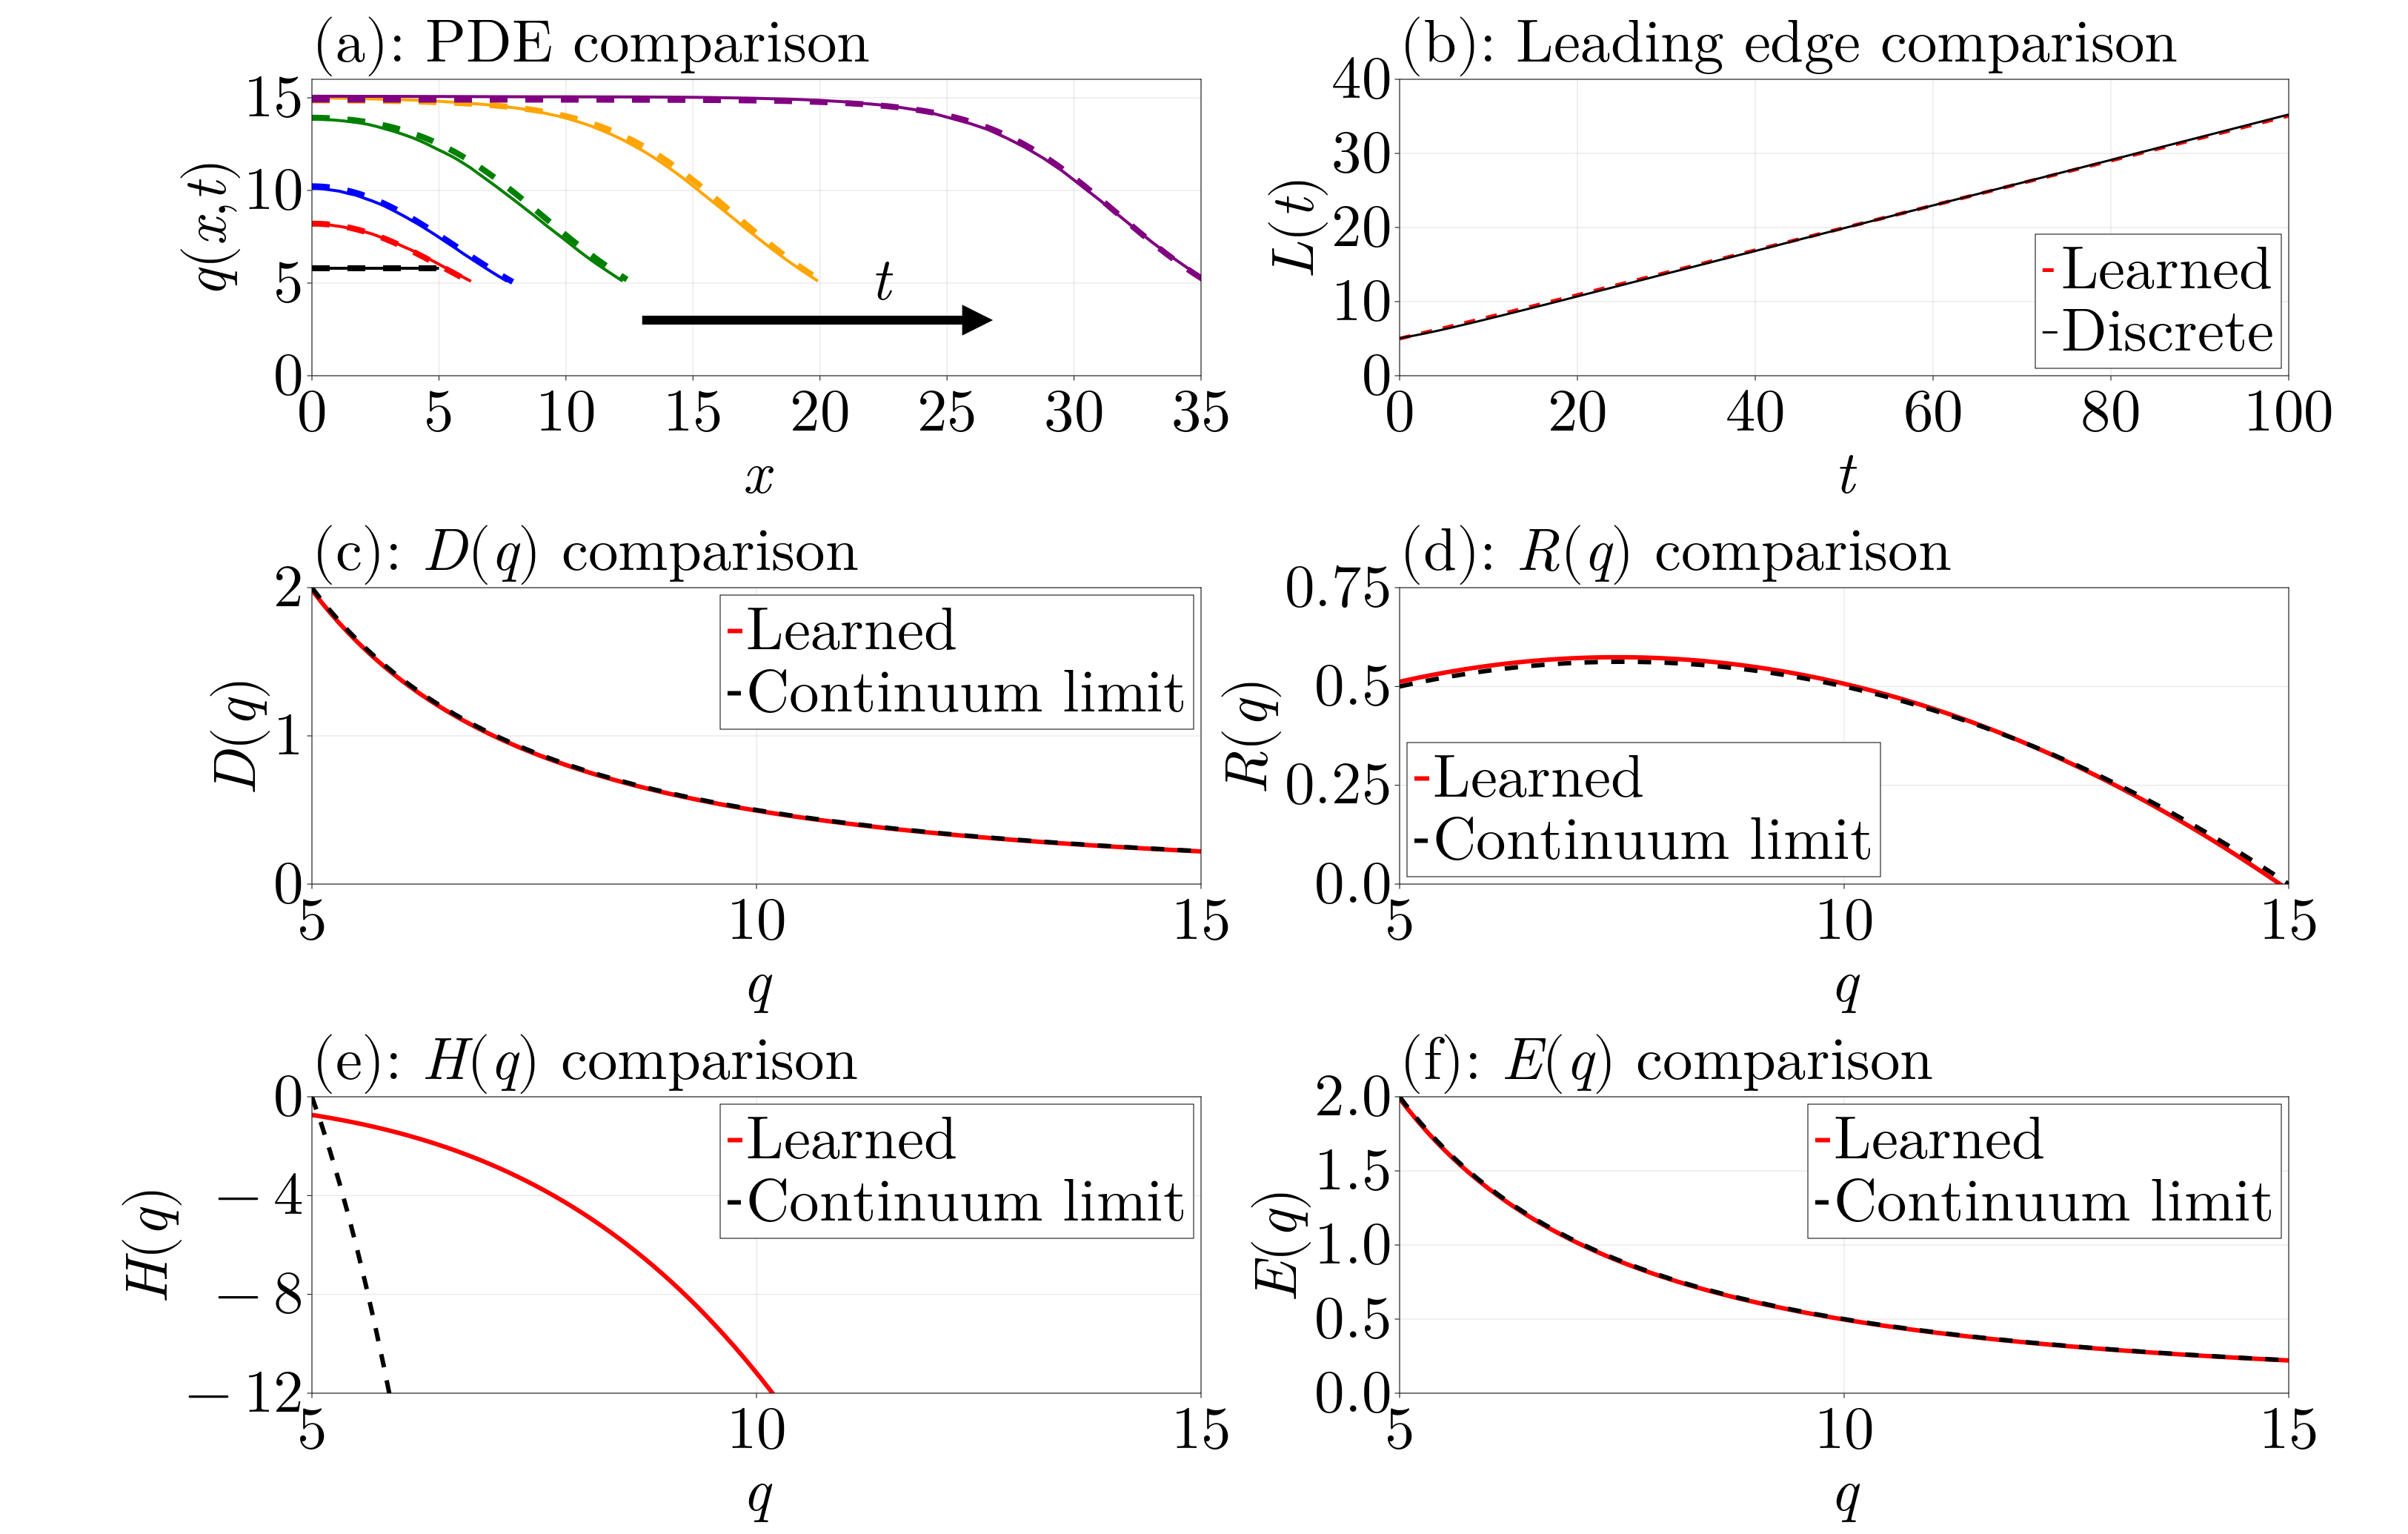

In [9]:
fig = Figure(fontsize=81, resolution=(3250, 2070))
ax_pde = Axis(fig[1, 1], xlabel=L"x", ylabel=L"q(x, t)",
    title=L"(a):$ $ PDE comparison", titlealign=:left,
    width=1200, height=400,
    xticks=(0:5:40, [L"%$s" for s in 0:5:40]),
    yticks=(0:5:15, [L"%$s" for s in 0:5:15])
)
xlims!(ax_pde, 0, 35)
ylims!(ax_pde, 0, 16)
ax_leading_edge = Axis(fig[1, 2], xlabel=L"t", ylabel=L"L(t)",
    title=L"(b):$ $ Leading edge comparison", titlealign=:left,
    width=1200, height=400,
    xticks=(0:20:100, [L"%$s" for s in 0:20:100]),
    yticks=(0:10:40, [L"%$s" for s in 0:10:40])
)
xlims!(ax_leading_edge, 0, 100)
ylims!(ax_leading_edge, 0, 40)
ax_dq = Axis(fig[2, 1], xlabel=L"q", ylabel=L"D(q)",
    title=L"(c): $D(q)$ comparison", titlealign=:left,
    width=1200, height=400,
    xticks=(5:5:15, [L"%$s" for s in 5:5:15]),
    yticks=(0:2, [L"%$s" for s in 0:2])
)
xlims!(ax_dq, 5, 15)
ylims!(ax_dq, 0, 2)
ax_rq = Axis(fig[2, 2], xlabel=L"q", ylabel=L"R(q)",
    title=L"(d): $R(q)$ comparison", titlealign=:left,
    width=1200, height=400,
    xticks=(5:5:15, [L"%$s" for s in 5:5:15]),
    yticks=(0:0.25:0.75, [L"%$s" for s in 0:0.25:0.75])
)
xlims!(ax_rq, 5, 15)
ylims!(ax_rq, 0, 0.75)
ax_hq = Axis(fig[3, 1], xlabel=L"q", ylabel=L"H(q)",
    title=L"(e): $H(q)$ comparison", titlealign=:left,
    width=1200, height=400,
    xticks=(5:5:15, [L"%$s" for s in 5:5:15]),
        yticks=(-12:4:0, [L"%$s" for s in -12:4:0])
)
xlims!(ax_hq, 5, 15)
ylims!(ax_hq, -12, 0)
ax_eq = Axis(fig[3, 2], xlabel=L"q", ylabel=L"E(q)",
    title=L"(f): $E(q)$ comparison", titlealign=:left,
    width=1200, height=400,
    xticks=(5:5:15, [L"%$s" for s in 5:5:15]),
        yticks=(0:0.5:2, [L"%$s" for s in 0:0.5:2])
)
xlims!(ax_eq, 5, 15)
ylims!(ax_eq, 0, 2)
time_indices = [findlast(≤(τ), esol[1].t) for τ in t]
colors = (:black, :red, :blue, :green, :orange, :purple, :brown)
pde_ξ = eql_sol_4.pde.geometry.mesh_points
pde_L = eql_sol_4.pde_sol[end, :]
pde_q = eql_sol_4.pde_sol[begin:(end-1), :]
cell_q = eql_sol_4.model.cell_sol.q
cell_r = eql_sol_4.model.cell_sol.u
cell_L = last.(eql_sol_4.model.cell_sol.u)

q_range = LinRange(5, 15, 100)
bc_q_range = LinRange(5, 5.8, 100)
D_cont_fnc = q -> (k / η) / q^2
R_cont_fnc = q -> β * q * (1 - q / K)
H_cont_fnc = q -> 2q^2 * (1 - q * s)
E_cont_fnc = D_cont_fnc
D_cont = D_cont_fnc.(q_range)
R_cont = R_cont_fnc.(q_range)
H_cont = H_cont_fnc.(q_range)
E_cont = E_cont_fnc.(q_range)
D_sol = diffusion_basis.(q_range, Ref(eql_sol.diffusion_theta), Ref(nothing))
R_sol = reaction_basis.(q_range, Ref(eql_sol_4.reaction_theta), Ref(nothing))
H_sol = rhs_basis.(q_range, Ref(eql_sol_3.rhs_theta), Ref(nothing))
E_sol = moving_boundary_basis.(q_range, Ref(eql_sol_2.moving_boundary_theta), Ref(nothing))

for (j, i) in enumerate(time_indices)
    lines!(ax_pde, pde_ξ * pde_L[i], pde_q[:, i], color=colors[j], linestyle=:dash, linewidth=8)
    lines!(ax_pde, cell_r[i], cell_q[i], color=colors[j], linewidth=4, label=L"%$(t[j])")
end
arrows!(ax_pde, [13.0], [3.0], [13.0], [0.0], color=:black, linewidth=12, arrowsize=57)
text!(ax_pde, [22.0], [3.5], text=L"t", fontsize=81)

lines!(ax_leading_edge, esol[1].t, pde_L, color=:red, linestyle=:dash, linewidth=5, label=L"$ $Learned")
lines!(ax_leading_edge, esol[1].t, cell_L, color=:black, linewidth=3, label=L"$ $Discrete")
axislegend(ax_leading_edge, position=:rb)

lines!(ax_dq, q_range, D_sol, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Learned")
lines!(ax_dq, q_range, D_cont, linewidth=6, color=:black, linestyle=:dash, label=L"$ $Continuum limit")
axislegend(ax_dq, position=:rt)

lines!(ax_rq, q_range, R_sol, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Learned")
lines!(ax_rq, q_range, R_cont, linewidth=6, color=:black, linestyle=:dash, label=L"$ $Continuum limit")
axislegend(ax_rq, position=:lb)

lines!(ax_hq, q_range, H_sol, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Learned")
lines!(ax_hq, q_range, H_cont, linewidth=6, color=:black, linestyle=:dash, label=L"$ $Continuum limit")
axislegend(ax_hq, position=:rt)

lines!(ax_eq, q_range, E_sol, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Learned")
lines!(ax_eq, q_range, E_cont, linewidth=6, color=:black, linestyle=:dash, label=L"$ $Continuum limit")
axislegend(ax_eq, position=:rt)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*